In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import pydeck as pdk
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings(
    "ignore",
    message=".*A worker stopped while some jobs were given to the executor.*",
    category=UserWarning
)

## Load Data

In [2]:
# Load satellite data (CHL, PAR, SST)
print('loading data...')
chl_ds   = xr.open_dataset('/Users/deliacarpenter/Desktop/Research/Primary Productivity CalCOFI/cmems satellite data original grid/cmems_obs-oc_glo_bgc-plankton_my_l3-multi-4km_P1D_CHL_126.98W-109.02W_22.02N-40.98N_1997-09-04-2020-01-25.nc')
par_ds   = xr.open_dataset('/Users/deliacarpenter/Desktop/Research/Primary Productivity CalCOFI/reindexed satellite data/reindexed_PAR_globcolour_4km_daily_merged_L3m.nc')
sst_ds   = xr.open_dataset('/Users/deliacarpenter/Desktop/Research/Primary Productivity CalCOFI/reindexed satellite data/reindexed_cmems_obs-sst_glo_phy_my_l3s_P1D-m_multi-vars_126.95W-109.05W_22.05N-40.95N_1997-09-04-2020-01-25.nc')
kd490_ds = xr.open_dataset('/Users/deliacarpenter/Desktop/Research/Primary Productivity CalCOFI/reindexed satellite data/reindexed_cmems_obs-oc_glo_bgc-transp_my_l3-multi-4km_P1D_KD490_126.98W-109.02W_22.02N-40.98N_1997-09-04-2020-01-25.nc')
C_ds     = xr.open_dataset('/Users/deliacarpenter/Desktop/Research/Primary Productivity CalCOFI/reindexed satellite data/reindexed_cmems_obs-oc_glo_bgc-optics_my_l3-multi-4km_P1D_BBP_and_phyto_C_126.98W-109.02W_22.02N-40.98N_1997-09-04-2020-01-25.nc')
mld_ds   = xr.open_dataset('/Users/deliacarpenter/Desktop/Research/Primary Productivity CalCOFI/reindexed satellite data/reindexed_cmems_mod_glo_phy_my_0.083deg_P1D-m_mlotst_127.00W-109.08W_22.08N-41.00N_1997-09-04-2020-01-25.nc')
chlc_ds  = xr.open_dataset('/Users/deliacarpenter/Desktop/Research/Primary Productivity CalCOFI/reindexed satellite data/reindexed_cmems_obs-oc_glo_bgc-optics_my_l3-multi-4km_P1D_CHLC_ratio_126.98W-109.02W_22.02N-40.98N_1997-09-04-2020-01-25.nc')
cdm_ds   = xr.open_dataset('/Users/deliacarpenter/Desktop/Research/Primary Productivity CalCOFI/reindexed satellite data/reindexed_cmems_obs-oc_glo_bgc-optics_my_l3-multi-4km_P1D_CDM_126.98W-109.02W_22.02N-40.98N_1997-09-04-2020-01-25.nc')
spm_ds   = xr.open_dataset('/Users/deliacarpenter/Desktop/Research/Primary Productivity CalCOFI/reindexed satellite data/reindexed_cmems_obs-oc_glo_bgc-transp_my_l3-multi-4km_P1D_SPM_126.98W-109.02W_22.02N-40.98N_1997-09-04-2020-01-25.nc')
phyt_ds  = xr.open_dataset('/Users/deliacarpenter/Desktop/Research/Primary Productivity CalCOFI/reindexed satellite data/reindexed_cmems_obs-oc_glo_bgc-plankton_my_l3-multi-4km_P1D_multi-vars_126.98W-109.02W_22.02N-40.98N_1997-09-04-2020-01-25.nc')
wind_ds  = xr.open_dataset('/Users/deliacarpenter/Desktop/Research/Primary Productivity CalCOFI/reindexed satellite data/reindexed_wind_ds.nc')
no3_ds   = xr.open_dataset('/Users/deliacarpenter/Desktop/Research/Primary Productivity CalCOFI/reindexed satellite data/reindexed_cmems_mod_glo_bgc_my_0.25deg_P1D-m_no3_127.00W-109.25W_22.25N-41.00N_0.51m_1997-09-04-2020-01-25.nc')
rrs_ds   = xr.open_dataset('/Users/deliacarpenter/Desktop/Research/Primary Productivity CalCOFI/reindexed satellite data/reindexed_cmems_obs-oc_glo_bgc-reflectance_my_l3-multi-4km_P1D_multi-vars_126.98W-109.02W_22.02N-40.98N_1997-09-04-2020-01-25.nc')
zsd_ds   = xr.open_dataset('/Users/deliacarpenter/Desktop/Research/Primary Productivity CalCOFI/reindexed satellite data/reindexed_cmems_obs-oc_glo_bgc-transp_my_l3-multi-4km_P1D_ZSD_126.98W-109.02W_22.02N-40.98N_1997-09-04-2020-01-25.nc')

# Make sure everything is an xarray.Dataset (not DataArray)
datasets_to_merge = [
    chl_ds,
    par_ds,
    sst_ds,
    kd490_ds,
    C_ds,
    mld_ds,
    chlc_ds,
    cdm_ds,
    spm_ds,
    phyt_ds,
    wind_ds,
    no3_ds,
    rrs_ds,
    zsd_ds,
]

# Align datasets
print("aligning...")
aligned = xr.align(*datasets_to_merge, join="inner")  # or try "inner" for safety

# Merge all datasets
print('merging data...')
#satellite_ds = xr.merge(datasets_to_merge)
satellite_ds = xr.merge(list(aligned))

loading data...
aligning...
merging data...


In [4]:
# Add MESD to satellite_ds

# Define representative diameters in microns for each group
d_pico = 0.7
d_nano = 5.0
d_micro = 50.0

# Pull the variables from the dataset
PICO = satellite_ds['PICO'].load()
NANO = satellite_ds['NANO'].load()
MICRO = satellite_ds['MICRO'].load()

# Compute biomass-weighted mean cell size (in microns)
numerator = (PICO * d_pico) + (NANO * d_nano) + (MICRO * d_micro)
denominator = PICO + NANO + MICRO

# Avoid divide-by-zero
MESD = xr.where(denominator > 0, numerator / denominator, np.nan)

# Assign to dataset
satellite_ds['MESD'] = MESD
satellite_ds['MESD'].attrs['units'] = 'µm'
satellite_ds['MESD'].attrs['long_name'] = 'Mean Estimated Spherical Diameter (biomass-weighted)'

del PICO, NANO, MICRO

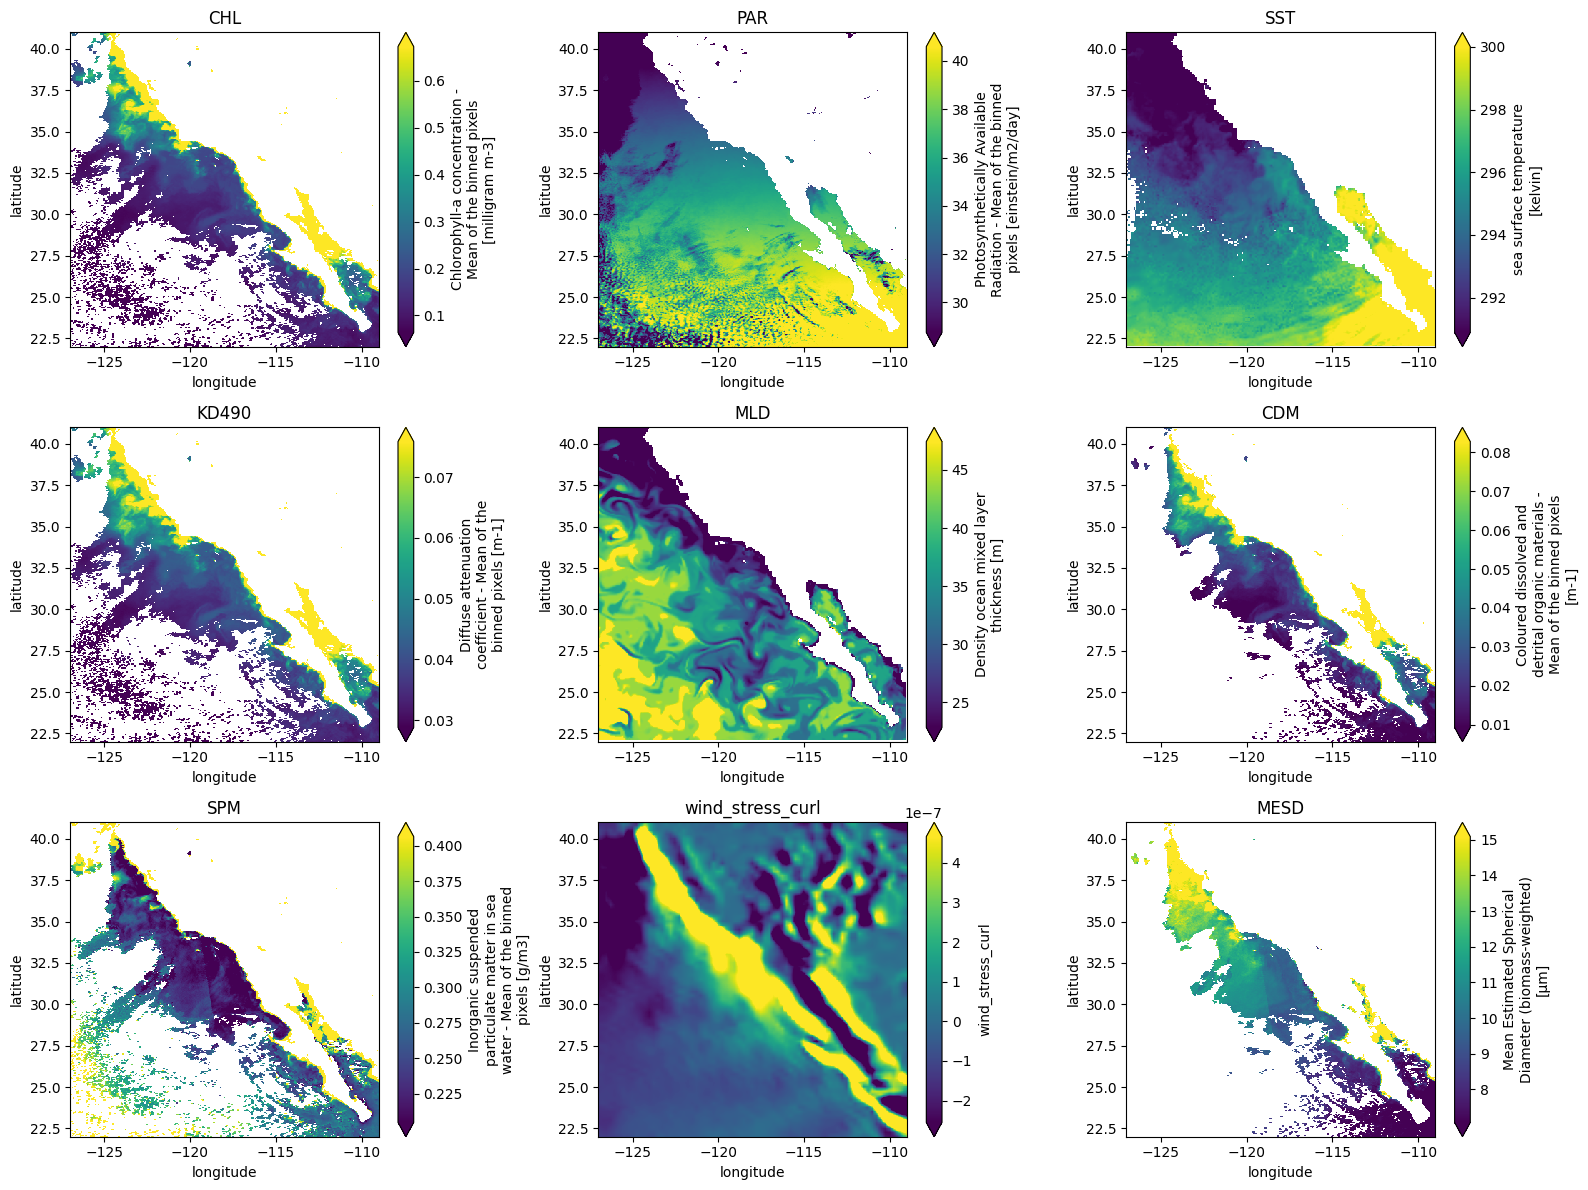

In [5]:
# Visualize one day of satellite data

# Select one day
date = '2015-10-30'
ds_day = satellite_ds.sel(time=date)

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
axs = axs.ravel()

vars_to_plot = ['CHL', 'PAR', 'SST', 
                'KD490', 'MLD', 'CDM', 
                'SPM', 'wind_stress_curl', 'MESD']

for i, var in enumerate(vars_to_plot):
    data = ds_day[var]
    values = data.values.flatten()
    values = values[~np.isnan(values)]  # remove NaNs

    # Compute 10th and 90th percentiles
    vmin = np.percentile(values, 10)
    vmax = np.percentile(values, 90)

    data.plot(ax=axs[i], cmap='viridis', vmin=vmin, vmax=vmax)
    axs[i].set_title(var)

plt.tight_layout()
plt.show()

## Define functions

In [6]:
def calculate_grid_window(res_km, target_area_km2=729, valid_fraction=1/3):
    """
    Calculate the size of an n x n satellite pixel grid that best approximates a target spatial area, 
    and determine the minimum number of valid pixels required within that grid based on a valid fraction.
    """
    
    # Calculate the ideal grid size (in pixels) to match the target spatial area
    ideal_grid_size = math.sqrt(target_area_km2 / (res_km ** 2))
    
    # Round ideal size to nearest integer to get base grid size
    base_grid_size = round(ideal_grid_size)
    
    # Find nearest odd integer grid sizes: one just below or equal, and one just above
    odd_floor = base_grid_size if base_grid_size % 2 == 1 else base_grid_size - 1
    odd_ceil = odd_floor + 2  # Next odd number above odd_floor
    
    # Compute the actual spatial areas these two grid sizes represent
    area_floor = (odd_floor * res_km) ** 2
    area_ceil = (odd_ceil * res_km) ** 2
    
    # Choose the odd grid size with the area closest to the target area
    if abs(area_floor - target_area_km2) <= abs(area_ceil - target_area_km2):
        n = odd_floor
    else:
        n = odd_ceil
    
    # Calculate total number of pixels in the grid window
    total_pixels = n ** 2
    
    # Calculate the minimum number of valid pixels required, rounding to nearest integer
    min_valid_pixels = int(valid_fraction * total_pixels + 0.5)
    
    return n, min_valid_pixels

In [7]:
# Load Integrated NPP Data from CalCOFI Bottle Survey
npp = pd.read_csv('../data/CalCOFI_Integrated_NPP.csv', index_col=0)
npp = npp[['Date', 'Latitude', 'Longitude', 'Integrated_NPP']]
npp['Date'] = pd.to_datetime(npp['Date'])
npp = npp.sort_values(by='Date').reset_index(drop=True)
npp = npp[npp.Date >= '1997-09-04'].reset_index(drop=True)

# Precompute nearest lat/lon indices
ds_lats = satellite_ds.latitude.values
ds_lons = satellite_ds.longitude.values

npp['ilat'] = np.abs(ds_lats[:, None] - npp['Latitude'].values).argmin(axis=0)
npp['ilon'] = np.abs(ds_lons[:, None] - npp['Longitude'].values).argmin(axis=0)

# Clip to valid range
npp['ilat'] = np.clip(npp['ilat'], 0, len(ds_lats) - 1)
npp['ilon'] = np.clip(npp['ilon'], 0, len(ds_lons) - 1)

# Calculate grid size and min_valid_pixels for satellite data
res_km = 4
grid_size, min_valid_pixels = calculate_grid_window(res_km)

# Precompute spatial window slices
half = grid_size // 2
npp['lat0'] = np.clip(npp['ilat'] - half, 0, len(ds_lats) - 1)
npp['lat1'] = np.clip(npp['ilat'] + half + 1, 0, len(ds_lats))
npp['lon0'] = np.clip(npp['ilon'] - half, 0, len(ds_lons) - 1)
npp['lon1'] = np.clip(npp['ilon'] + half + 1, 0, len(ds_lons))

# Get nearest time index for each NPP observation
ds_times = satellite_ds.time.values.astype('datetime64[D]')
npp_times = npp['Date'].values.astype('datetime64[D]')

npp['itime'] = np.searchsorted(ds_times, npp_times)
npp['itime'] = np.clip(npp['itime'], 0, len(ds_times) - 1)

In [21]:
def extract_satellite_features(i, var, min_valid_pixels, max_day_offset=3):
    ''' Return an (n x n) spatial grid for variable 'var' for lags [-14, -7, 0, 7, 14], computing the following:
        - Instantaneous satellite grid values for lags [-14, -7, 0, 7, 14]
        - Mean over time windows [past two weeks, past week, this week, this and next week, this and next two weeks]
        - Variance over different time windows [past two weeks, past week, this week, this and next week, this and next two weeks]
    '''
    
    # Time indices for instantaneous values (±3-day window around the target lag)
    LAG_WINDOWS = {
        -14: (-17, -11),
        -7:  (-10, -4),
        0:  (-3,  3),
        7:  ( 4, 10),
        14:  (11, 17),
    }
    # Time indices for moving windows (moving-window statistics over all days you want to include)
    WINDOW_INDICES = {
        -14: (-17, 3),
        -7:  (-10, 3),
        0:  (-3, 3),
        7:  (-3, 10),
        14:  (-3, 17)
    }
    row = npp.loc[i]
    lat0, lat1, lon0, lon1, itime = row.lat0, row.lat1, row.lon0, row.lon1, row.itime
    
    # --- Subset full temporal cube for this NPP observation ---
    t0 = max(itime - 17, 0)
    t1 = min(itime + 18, satellite_ds.sizes['time'])
    da = satellite_ds[var].isel(
        time=slice(t0, t1),
        latitude=slice(lat0, lat1),
        longitude=slice(lon0, lon1)
    )

    # Map absolute time to relative index in da
    rel_itime = itime - t0

    lags = [-14, -7, 0, 7, 14]
    moving_window_stats = ['value', 'mean', 'variance']

    results = {}
    for stat in moving_window_stats:
        for lag in lags:
            # Find satellite values for nearest day
            if stat == 'value':
                # t0_lag_rel, t1_lag_rel = LAG_WINDOWS[lag]
                found = False
                for offset in range(max_day_offset + 1):
                    for direction in [-1,1] if offset > 0 else[0]:    # do offset 0 first, then ±1, ±2...
                        t_idx = rel_itime + lag + direction * offset
                        if t_idx < 0 or t_idx >= da.sizes['time']:    # for t_idxs near the end of the time series
                            continue
                        sat_day = da.isel(time=t_idx)
                        if np.isfinite(sat_day).sum() >= min_valid_pixels:
                            # results[f'{var}_value_{lag}'] = sat_day
                            found = True
                            break
                    if found:
                        break
                if not found:
                    results[f'{var}_value_{lag}'] = np.full((da.sizes['latitude'], da.sizes['longitude']),np.nan,dtype=np.float32)
                    results[f'date_{lag}'] = pd.NaT    # no valid date found
                else:
                    results[f'{var}_value_{lag}'] = sat_day
                    results[f'date_{lag}'] = pd.Timestamp(satellite_ds.time.values[t0+t_idx])
    
            # Take moving_window_stat over specified window
            elif stat in ['mean', 'variance']:
                t0_rel_idx, t1_rel_idx = WINDOW_INDICES[lag]
                t0_rel_idx = rel_itime + t0_rel_idx
                t1_rel_idx = rel_itime + t1_rel_idx
                sat_cube = da.isel(time=slice(t0_rel_idx, t1_rel_idx+1))
    
                if stat == 'mean':
                    grid = sat_cube.mean(axis=0) # average over time only
                elif stat == 'variance':
                    grid = sat_cube.var(axis=0)  # variance over time only
    
                results[f'{var}_{stat}_{lag}'] = grid
    
    return results

i = 1000
var = 'CHL'

features = extract_satellite_features(i, var, min_valid_pixels, max_day_offset=3)
for key in features.keys():
    print(key)

CHL_value_-14
date_-14
CHL_value_-7
date_-7
CHL_value_0
date_0
CHL_value_7
date_7
CHL_value_14
date_14
CHL_mean_-14
CHL_mean_-7
CHL_mean_0
CHL_mean_7
CHL_mean_14
CHL_variance_-14
CHL_variance_-7
CHL_variance_0
CHL_variance_7
CHL_variance_14


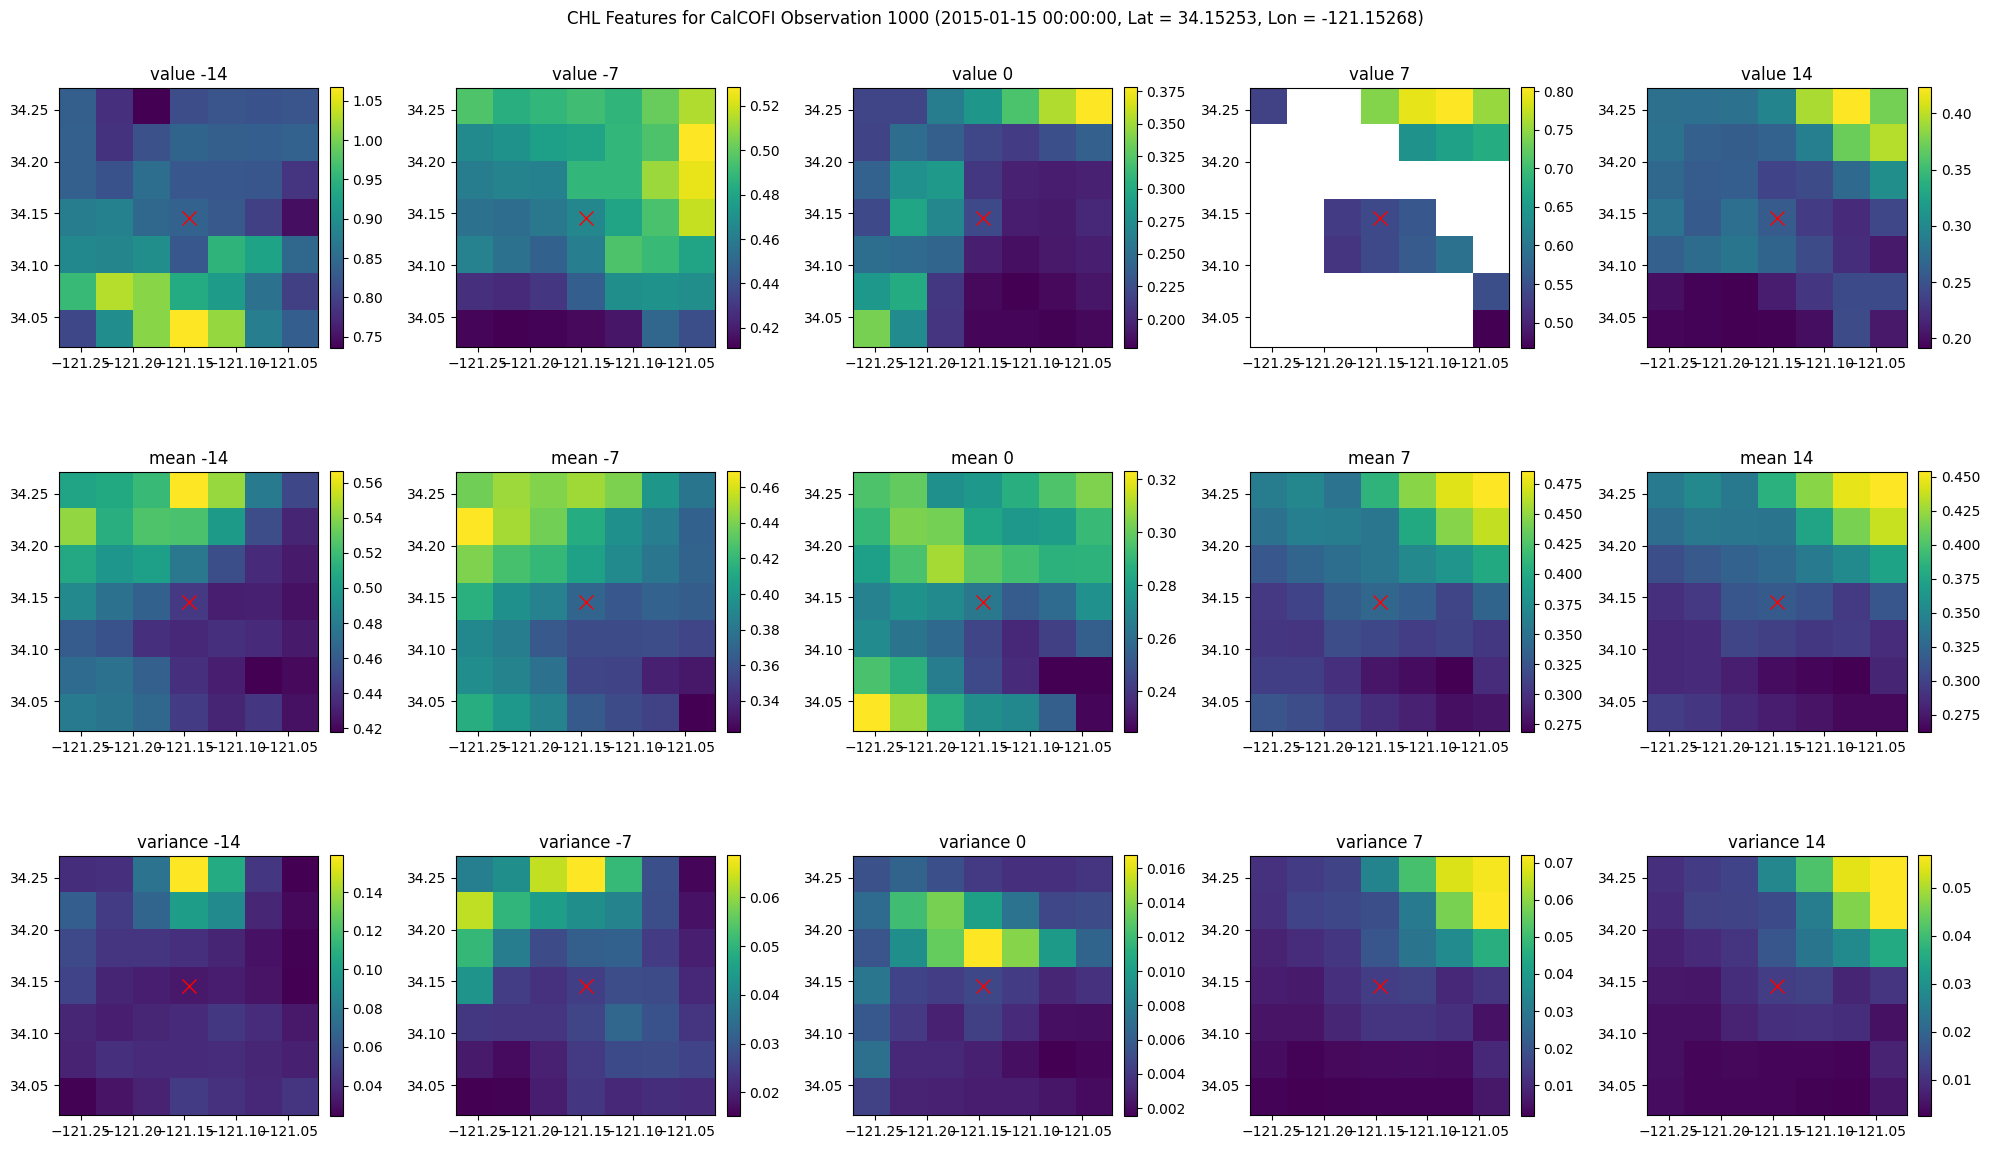

In [22]:
# Visualize features of one variable for one NPP observation

lags = [-14, -7, 0, 7, 14]
stats = ['value', 'mean', 'variance']

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12), sharex=False, sharey=False)
fig.suptitle(f'{var} Features for CalCOFI Observation {i} ({npp.loc[i, 'Date']}, Lat = {npp.loc[i, 'Latitude']}, Lon = {npp.loc[i, 'Longitude']})')

for i, stat in enumerate(stats):
    for j, lag in enumerate(lags):
        ax = axes[i, j]
        key = f'{var}_{stat}_{lag}'
        grid = features[key]
        
        # Convert to numpy array if xarray
        if hasattr(grid, 'values'):
            grid_data = grid.values
            lat = grid.latitude.values
            lon = grid.longitude.values
        else:
            grid_data = grid
            lat = np.arange(grid.shape[0])
            lon = np.arange(grid.shape[1])
        
        im = ax.imshow(grid_data, origin='lower', cmap='viridis',
                       extent=[lon[0], lon[-1], lat[0], lat[-1]])
        ax.set_title(f'{stat} {lag}')
        
        # Plot NPP observation as red X in center of grid
        lat_c = lat[len(lat)//2]
        lon_c = lon[len(lon)//2]
        ax.plot(lon_c, lat_c, 'rx', markersize=10)
        
        fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [28]:
def process_var(var):

    lags = [-14, -7, 0, 7, 14]
    moving_window_stats = ['value', 'mean', 'variance']
    
    results_list = Parallel(n_jobs=-1, backend='threading')(
        delayed(extract_satellite_features)(i, var, min_valid_pixels)
        for i in tqdm(npp.index)
    )

    # convert results to xarray.Dataset
    data_vars = {}
    for stat in moving_window_stats:
        for lag in lags:
            arr = np.stack([res[f'{var}_{stat}_{lag}'] for res in results_list], axis=0)
            data_vars[f'{stat}_{lag}'] = (('npp', 'lat', 'lon'), arr)

    # Collect selected dates for each value lag
    selected_dates = {}
    for lag in lags:
        dates_arr = np.array(
            [res[f'date_{lag}'] if res[f'date_{lag}'] is not pd.NaT else np.datetime64('NaT') 
             for res in results_list],
            dtype='datetime64[ns]'
        )
        selected_dates[f'selected_date_{lag}'] = ('npp', dates_arr)
    
    ds = xr.Dataset(
        data_vars=data_vars,
        coords={
            'npp': npp.index.values,
            'lat': results_list[0][f'{var}_value_-14'].latitude.values,
            'lon': results_list[0][f'{var}_value_-14'].longitude.values,
            'date': ('npp', npp['Date'].values),
            **selected_dates
        }
    )
    

    return ds

# Run for all variables
input_vars = ['CHL'] #, 'PAR', 'SST', 'KD490', 'BBP', 'C', 'MLD', 'CHL:C', 'CDM', 'SPM', 
              # 'DIATO', 'DINO', 'GREEN', 'HAPTO', 'MICRO', 'NANO', 'PICO', 'PROCHLO', 'PROKAR', 
              # 'u10', 'v10', 'wind_stress_curl', 'no3', 
              # 'RRS412', 'RRS443', 'RRS490', 'RRS555', 'RRS670', 
              # 'ZSD', 'MESD']

for var in input_vars:
    print(var)
    var_ds = process_var(var)
    #encoding = {varname: {'zlib': True, 'complevel': 4} for varname in var_ds.data_vars}
    var_ds.to_netcdf(f'satellite_features/{var}.nc', encoding=encoding, engine='netcdf4')

CHL


100%|███████████████████████████████████████| 1265/1265 [00:55<00:00, 22.96it/s]


ModuleNotFoundError: No module named 'netCDF4'

In [32]:
#var_ds.to_netcdf(f'satellite_features/{var}.nc', engine='netcdf4')

var_ds = xr.open_dataset('satellite_features/CHL.nc')

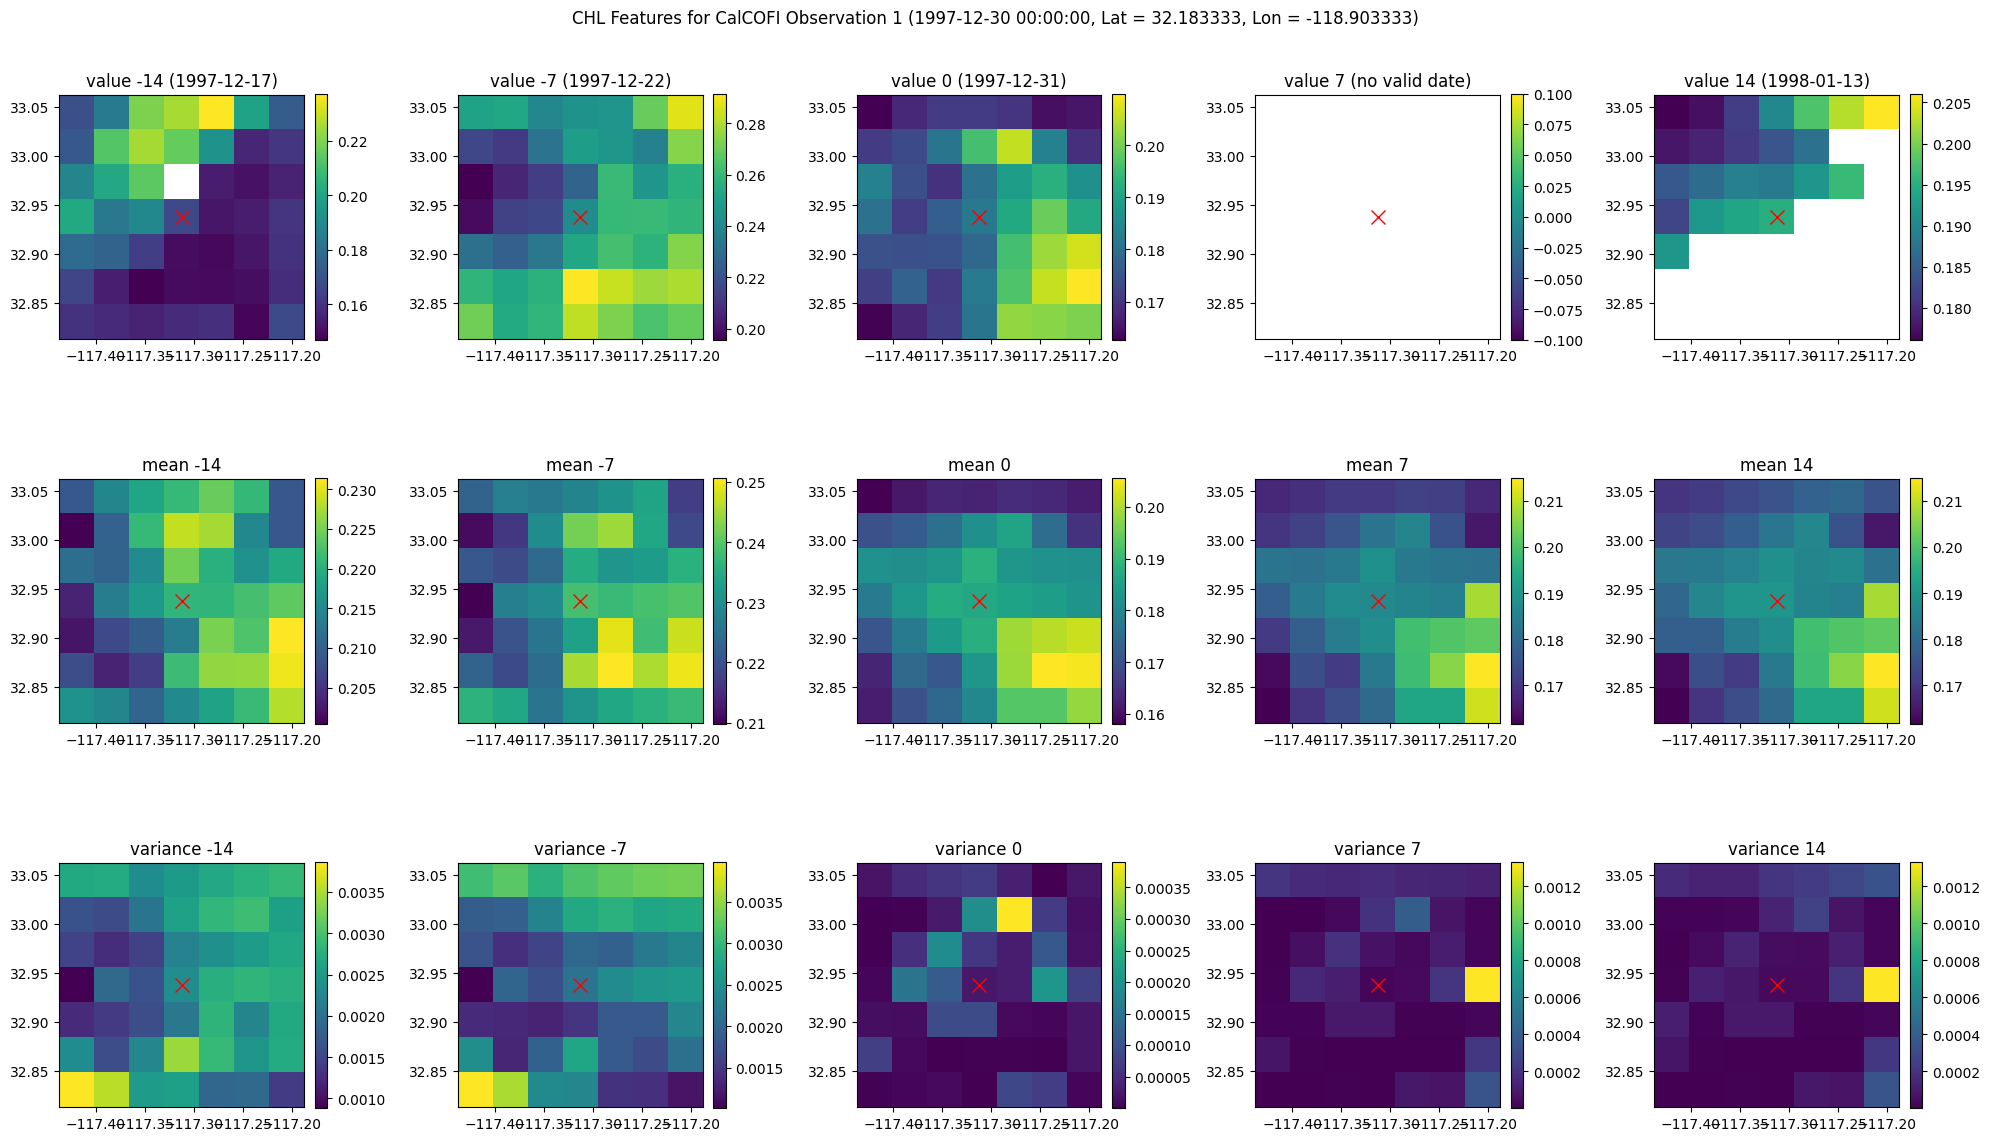

In [33]:
# Visualize features for an NPP observation and variable using var_ds.

obs_i = 1  # change to whichever NPP observation you want
var = 'CHL'

lags = [-14, -7, 0, 7, 14]
stats = ['value', 'mean', 'variance']

lat = var_ds.lat.values
lon = var_ds.lon.values
lat_c = lat[len(lat) // 2]
lon_c = lon[len(lon) // 2]

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12), sharex=False, sharey=False)
fig.suptitle(f'{var} Features for CalCOFI Observation {obs_i} ({npp.loc[obs_i, "Date"]}, Lat = {npp.loc[obs_i, "Latitude"]}, Lon = {npp.loc[obs_i, "Longitude"]})')

for i, stat in enumerate(stats):
    for j, lag in enumerate(lags):
        ax = axes[i, j]
        grid_data = var_ds[f'{stat}_{lag}'].sel(npp=obs_i).values

        im = ax.imshow(grid_data, origin='lower', cmap='viridis',
                       extent=[lon[0], lon[-1], lat[0], lat[-1]])

        if stat == 'value':
            chosen_date = var_ds[f'selected_date_{lag}'].sel(npp=obs_i).values
            if pd.isnull(chosen_date):
                title = f'value {lag} (no valid date)'
            else:
                title = f'value {lag} ({pd.Timestamp(chosen_date).strftime("%Y-%m-%d")})'
        else:
            title = f'{stat} {lag}'

        
        ax.set_title(title)
        ax.plot(lon_c, lat_c, 'rx', markersize=10)
        fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [34]:
var_ds

<xarray.Dataset> Size: 4MB
Dimensions:            (npp: 1265, lat: 7, lon: 7)
Coordinates:
  * npp                (npp) int64 10kB 0 1 2 3 4 5 ... 1260 1261 1262 1263 1264
  * lat                (lat) float32 28B 32.81 32.85 32.9 ... 32.98 33.02 33.06
  * lon                (lon) float32 28B -117.4 -117.4 -117.4 ... -117.2 -117.2
    date               (npp) datetime64[ns] 10kB ...
    selected_date_-14  (npp) datetime64[ns] 10kB ...
    selected_date_-7   (npp) datetime64[ns] 10kB ...
    selected_date_0    (npp) datetime64[ns] 10kB ...
    selected_date_7    (npp) datetime64[ns] 10kB ...
    selected_date_14   (npp) datetime64[ns] 10kB ...
Data variables: (12/15)
    value_-14          (npp, lat, lon) float32 248kB ...
    value_-7           (npp, lat, lon) float32 248kB ...
    value_0            (npp, lat, lon) float32 248kB ...
    value_7            (npp, lat, lon) float32 248kB ...
    value_14           (npp, lat, lon) float32 248kB ...
    mean_-14           (npp, lat, lon) float32 248kB ...
    ...                 ...
    mean_14            (npp, lat, lon) float32 248kB ...
    variance_-14       (npp, lat, lon) float32 248kB ...
    variance_-7        (npp, lat, lon) float32 248kB ...
    variance_0         (npp, lat, lon) float32 248kB ...
    variance_7         (npp, lat, lon) float32 248kB ...
    variance_14        (npp, lat, lon) float32 248kB ...

In [36]:
def eppley_square_root(row):
    """
    Compute Eppley square root NPP estimate and its standard deviation for a single row.

    Parameters:
    row : pd.Series
        Row with 'CHL_values'
    scale_std : bool
        Whether to apply Kahru et al. scale factor to the standard deviation (to make comparable to 9km data).

    Returns:
    dict with 'Satellite_NPP (ESQRT)' and 'Satellite_NPP_std (ESQRT)'
    """

    chl_values = row.get('CHL_values_lag_0')
    if chl_values is None or np.all(np.isnan(chl_values)):
        return {'Satellite_NPP (ESQRT)': np.nan, 'Satellite_NPP_std (ESQRT)': np.nan}

    # Get valid CHL values
    chl_array = np.array(chl_values).flatten()
    valid_chl = chl_array[(chl_array > 0) & np.isfinite(chl_array)]

    if len(valid_chl) == 0:
        return {'Satellite_NPP (ESQRT)': np.nan, 'Satellite_NPP_std (ESQRT)': np.nan}

    # Compute NPP for each valid pixel
    npp_values = 1000 * np.sqrt(valid_chl)

    # Calculate mean and std of NPP estimates
    npp_mean = np.mean(npp_values)
    npp_std = np.std(npp_values)

    return {'Satellite_NPP (ESQRT)': npp_mean, 'Satellite_NPP_std (ESQRT)': npp_std}

In [64]:
# Build a dataframe with CHL_values_lag_0 extracted from var_ds
chl_df = npp[['Date', 'Latitude', 'Longitude', 'Integrated_NPP']].copy()
chl_df['CHL_values_lag_0'] = [
    var_ds['value_0'].sel(npp=i).values for i in npp.index
]

# Apply Eppley square root model
esqrt_results = chl_df.apply(eppley_square_root, axis=1, result_type='expand')
chl_df = pd.concat([chl_df, esqrt_results], axis=1)

display(chl_df)

,Date,Latitude,Longitude,Integrated_NPP,CHL_values_lag_0,Satellite_NPP (ESQRT),Satellite_NPP_std (ESQRT)
0,1997-12-29,32.955000,-117.303333,1105.2000,"[[0.50337034, 0.5042391, 0.51523197, 0.48625, ...",701.263000,39.945415
1,1997-12-30,32.183333,-118.903333,672.5520,"[[0.1629029, 0.16763091, 0.17112373, 0.1810068...",426.528381,15.512173
2,1997-12-31,31.183333,-120.928333,344.9880,"[[0.13251944, 0.13593358, 0.13133064, 0.125739...",358.236755,6.738063
3,1998-01-01,29.848333,-123.586666,143.3250,"[[0.105788484, 0.10614791, 0.11172756, 0.11103...",334.319305,4.904779
4,1998-01-02,31.096666,-122.670000,231.8760,"[[0.14366503, 0.144713, 0.14440304, 0.14089857...",380.336060,6.869258
...,...,...,...,...,...,...,...
1260,2020-01-18,32.911420,-122.123980,763.7526,"[[0.3563891, 0.3546127, 0.35024187, 0.32303068...",614.188354,24.270636
1261,2020-01-19,33.876830,-120.136830,1694.6613,"[[2.3160365, 2.325411, 2.4427543, 2.4863403, n...",1607.550903,139.160736
1262,2020-01-20,33.143670,-123.220220,244.2384,"[[0.31746548, 0.3259248, 0.329945, 0.2913743, ...",597.477600,40.381283
1263,2020-01-21,34.049580,-122.941280,789.3189,"[[0.22750743, 0.251432, 0.25463256, 0.29975435...",470.929321,26.039404


In [38]:
def make_scatter_plot(result_df, model_name, ax=None):

    # # Calculate summary statistics (on log-transformed data)
    result_df = result_df[['Integrated_NPP', f'Satellite_NPP ({model_name})', f'Satellite_NPP_std ({model_name})']].copy().dropna()
    log_x = np.log10(result_df['Integrated_NPP'].values)
    log_y = np.log10(result_df[f'Satellite_NPP ({model_name})'].values)

    # Linear regression in log-log space
    model = LinearRegression()
    model.fit(log_x.reshape(-1, 1), log_y)
    log_y_pred = model.predict(log_x.reshape(-1, 1))
    r2 = r2_score(log_y, log_y_pred)
    rmse = np.sqrt(mean_squared_error(log_y, log_y_pred))
    rmsd = np.sqrt(np.mean((log_y - log_y_pred)**2))
    slope = model.coef_[0]
    intercept = model.intercept_
    corr = np.corrcoef(result_df['Integrated_NPP'], result_df[f'Satellite_NPP ({model_name})'])[0,1]
    log_corr = np.corrcoef(log_x, log_y)[0,1]
    n = len(result_df)

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    
    ax.errorbar(
        result_df['Integrated_NPP'], 
        result_df[f'Satellite_NPP ({model_name})'], 
        yerr=result_df[f'Satellite_NPP_std ({model_name})'], 
        fmt='none',           # no marker (we already have scatterplot)
        ecolor='gray',        # color of error bars
        alpha=0.4,            # transparency
        capsize=2,            # caps on error bars
        elinewidth=1,
        label='±1 Std Dev',
        zorder=1
    )
    
    # Re-transform regression line to original scale
    x_range = np.logspace(np.log10(result_df['Integrated_NPP'].min()), np.log10(result_df['Integrated_NPP'].max()), 100)
    y_fit = 10 ** model.predict(np.log10(x_range).reshape(-1, 1))
    
    if ax is None:
        sns.scatterplot(data=result_df, x='Integrated_NPP', y=f'Satellite_NPP ({model_name})', s=20, alpha=0.8)
    else:
        sns.scatterplot(data=result_df, x='Integrated_NPP', y=f'Satellite_NPP ({model_name})', ax=ax, s=20, alpha=0.8)
        
    # Add regression line
    ax.plot(x_range, y_fit, color='red', label='Regression line')
    
    # Add 1:1, 1:2, and 1:3 lines
    min_val = min(result_df[['Integrated_NPP', f'Satellite_NPP ({model_name})']].min())
    max_val = max(result_df[['Integrated_NPP', f'Satellite_NPP ({model_name})']].max())
    ax.plot(x_range, x_range, 'k--', label='1:1 line', alpha=0.5)
    ax.plot(x_range, x_range / 2, 'k:', label='1:2 line', alpha=0.5)
    ax.plot(x_range, x_range / 3, 'k-.', label='1:3 line', alpha=0.5)
    
    # Labels, scales, title
    ax.set_xlabel('In situ NPP (mg C/m²/day)')
    ax.set_ylabel(f'Satellite NPP ({model_name})')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'Satellite vs. In Situ NPP ({model_name})')

    # Add R², RMSE, N as text
    ax.text(0.05, 0.95, 
            f'$R^2$ = {r2:.2f}\n'
            f'RMSE = {rmse:.2f}\n'
            f'RMSD = {rmsd:.2f}\n'
            f'Slope = {slope:.3f}\nIntercept = {intercept:.3f}\n'
            f'ρ = {corr:.3f}\n'
            f'ρ (log-log) = {log_corr:.3f}\n'
            f'N = {n}',
            transform=ax.transAxes, 
            verticalalignment='top',
            fontsize=9,
            bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
    
    ax.grid(True, which='both', ls=':')
    ax.legend(loc='lower right')

    return ax

<Axes: title={'center': 'Satellite vs. In Situ NPP (ESQRT)'}, xlabel='In situ NPP (mg C/m²/day)', ylabel='Satellite NPP (ESQRT)'>

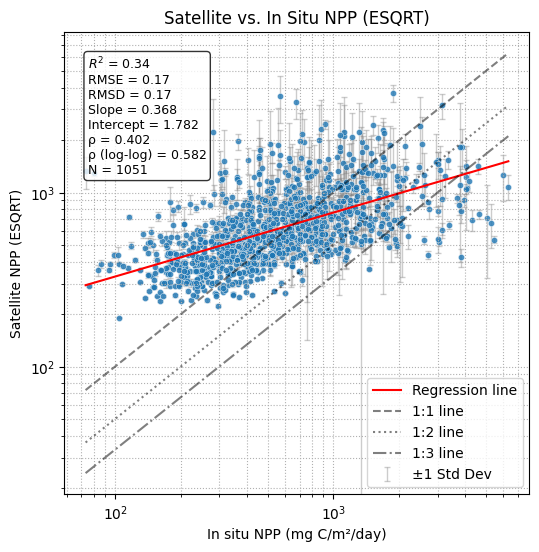

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

result_df = chl_df[['Integrated_NPP', 'Satellite_NPP (ESQRT)', 'Satellite_NPP_std (ESQRT)']].copy()
result_df = result_df.dropna()
result_df = result_df[
    (result_df['Integrated_NPP'] > 0) & 
    (result_df[f'Satellite_NPP (ESQRT)'] > 0)
]
make_scatter_plot(result_df, 'ESQRT')